In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from experiments.evaluation.loading import load

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
reload = False

# Normal distribution
folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-11-03/12-29-52/",  # hidden, visible_changing
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-11-03/19-59-39",  # visibile_all, cgate_hadamard, cgate_lstm
]

# Uniform distribution
folders_eval = [
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-11-07/20-45-00"  # all visibilities
]
df = pd.concat([load(folder_eval=folder_eval, rpc_fn=f"tmp/rpc_context_efficiency_{i}.csv", reload_rpc=reload) for i, folder_eval in enumerate(folders_eval)]).reset_index(drop=True)
df = df[df["n_contexts"] < 256]
df["n_contexts_log"] = df["n_contexts"].apply(lambda x: np.log(x)/np.log(2))  # n_contexts are 1,2,4,8,16,... power of 2

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:181: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


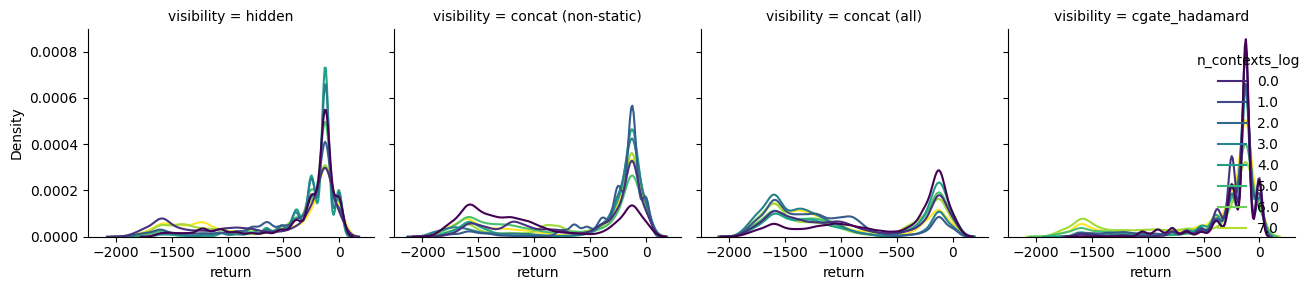

/home/benjamin/.conda/envs/carl/lib/python3.10/site-packages/seaborn/axisgrid.py:181: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


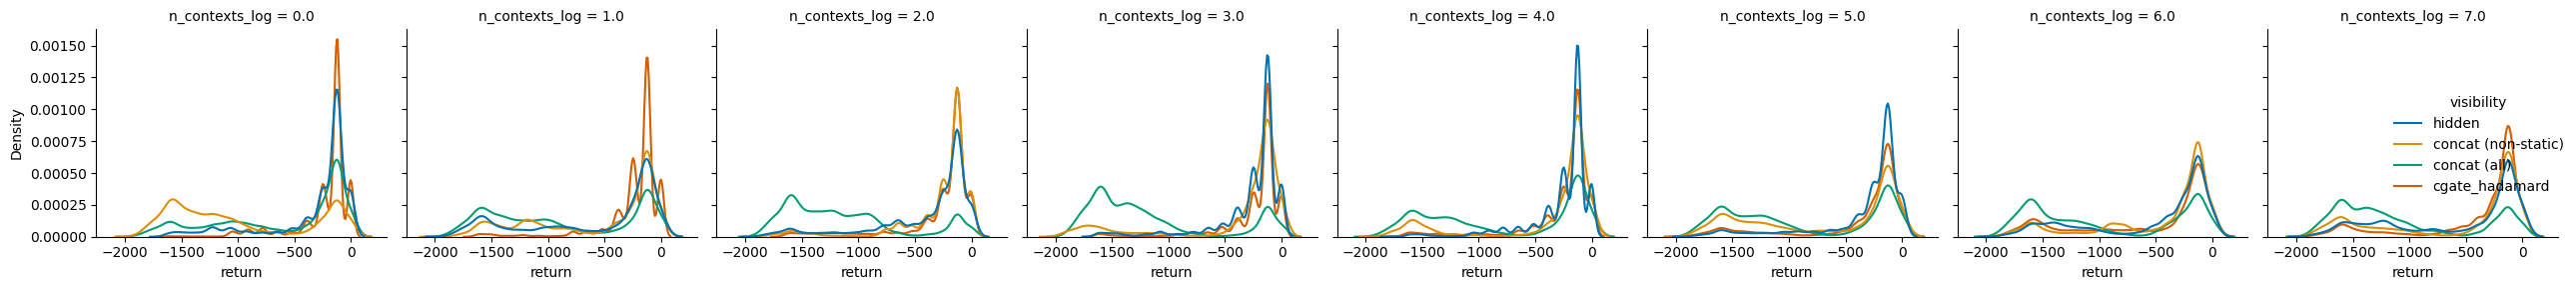

In [14]:
from pathlib import Path
from matplotlib.lines import Line2D

def get_legend_handles(df, hue, palette="colorblind"):
    hues = df[hue].unique()
    palette = sns.color_palette(palette=palette, n_colors=len(hues))
    palette = {n: c for n, c in zip(hues, palette)}
    handles = [Line2D([0], [0], color=c, label=n) for n, c in palette.items()]
    return handles

fig_fn = Path("tmp/figures/context_efficiency/col_visibility_hue_ncontexts.png")
fig_fn.parent.mkdir(exist_ok=True, parents=True)
col = "visibility"
hue = "n_contexts_log"
palette = "viridis"
handles = get_legend_handles(df=df, hue=hue, palette=palette)
grid = sns.FacetGrid(data=df, col=col, legend_out=True)
grid = grid.map_dataframe(sns.kdeplot, x="return", hue=hue, palette=palette)
grid = grid.add_legend(handles=handles, title=hue)
grid.figure.set_tight_layout(True)
grid.figure.savefig(fig_fn, dpi=300, bbox_inches="tight")
plt.show()

fig_fn = Path("tmp/figures/context_efficiency/col_ncontexts_hue_visibility.png")
fig_fn.parent.mkdir(exist_ok=True, parents=True)
col = "n_contexts_log"
hue = "visibility"
palette = "colorblind"
handles = get_legend_handles(df=df, hue=hue, palette=palette)
grid = sns.FacetGrid(data=df, col=col, legend_out=True)
grid = grid.map_dataframe(sns.kdeplot, x="return", hue=hue, palette=palette)
grid = grid.add_legend(handles=handles, title=hue)
grid.figure.set_tight_layout(True)
grid.figure.savefig(fig_fn, dpi=300, bbox_inches="tight")
plt.show()



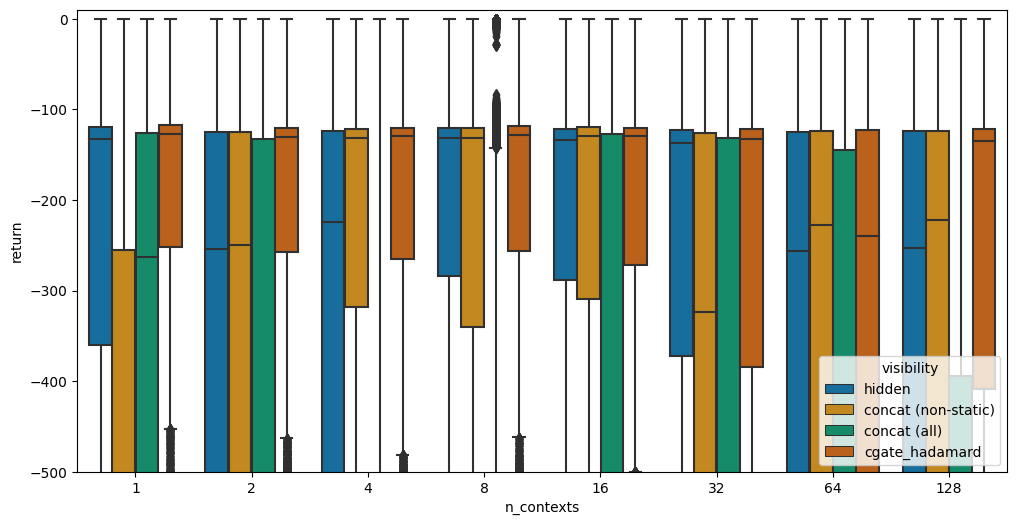

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
# ax = sns.violinplot(data=df, x="n_contexts", y="return", hue="visibility", cut=0, ax=ax)
# ax = sns.lineplot(data=df, x="n_contexts", y="return", hue="visibility", ax=ax)
ax = sns.boxplot(data=df, x="n_contexts", y="return", hue="visibility", ax=ax)
ax.set_ylim(-500, 10)
plt.show()

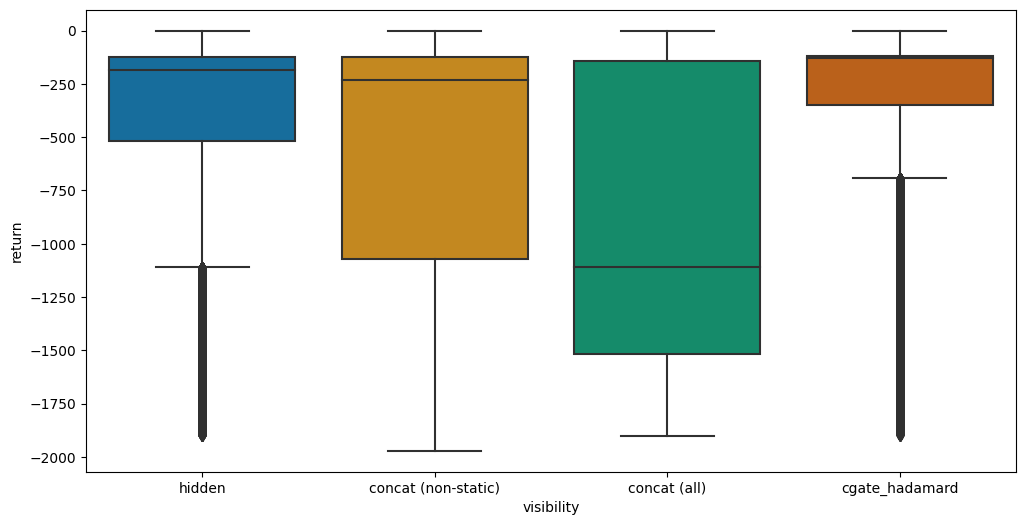

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette("colorblind")
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111)
ax = sns.boxplot(data=df, x="visibility", y="return", hue=None, ax=ax)
# ax.set_ylim(-500, 10)
plt.show()

In [6]:
from rliable import library as rly
from rliable import metrics
from rliable import plot_utils

filtered_df = df.copy()
# filtered_df = filtered_df[(filtered_df["seed"] != 7) & (filtered_df["seed"] != 8) & (filtered_df["seed"] != 2) & (filtered_df["seed"] != 4)]
reps = 10000
n_reps = 10  # 10 episodes per context
xlabel = ""
group_key = "visibility"

metric_names = ['Median', 'IQM', 'Mean']  # , 'Optimality Gap']
aggregate_func = lambda x: np.array([
  metrics.aggregate_median(x),
  metrics.aggregate_iqm(x),
  metrics.aggregate_mean(x),
  # metrics.aggregate_optimality_gap(x)
  ])


# Create score matrix
# Scores: (num_points x num_tasks), here:
#         (num_seeds * num_reps x num_tasks)
# Pendulum: num_tasks = n_contexts = 100
score_dict = {}
for group_id, group_df in filtered_df.groupby(group_key):
  n_seeds = group_df["seed"].nunique()
  n_context_ids = group_df["context_id"].nunique()
  print(n_seeds, n_context_ids)
  scores = np.zeros((n_seeds * n_reps, n_context_ids))
  for i, ((seed, rep), gdf) in enumerate(group_df.groupby(["seed", "rep"])):
    R = gdf["return"]
    n = len(gdf)
    index = (seed - 1) * n_seeds + rep  # seed is 1-based
    scores[i] = R
  score_dict[group_id] = scores


aggregate_scores, aggregate_score_cis = rly.get_interval_estimates(
        score_dict, aggregate_func, reps=reps)


fig, axes = plot_utils.plot_interval_estimates(
    aggregate_scores, aggregate_score_cis,
    metric_names=metric_names,
    algorithms=list(score_dict.keys()), xlabel=xlabel)
# fig.set_tight_layout(True)
plt.show()

10 1


ValueError: could not broadcast input array from shape (8,) into shape (1,)

In [13]:
df.columns
df["context_id"].unique()

array([0])